In [34]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import time
import random
import os

In [35]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("using cuda")
else:
    DEVICE = torch.device('cpu')
    print("using cpu")

using cuda


In [36]:
def switch_to_device(dataset, device = None):
    tensor_list_X, tensor_list_Y = [], []
    for x, y in dataset:
        tensor_list_X.append(x)
        tensor_list_Y.append(y)
    
    X = torch.stack(tensor_list_X)
    Y = torch.tensor(tensor_list_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)

In [37]:
def get_mnist_dl(batch_size_train = 256, batch_size_valid = 1024, device = None):
    #transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train = True, download = True, transform = transform)
    data_train = switch_to_device(data_train, device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000, 5000])

    data_test = MNIST('./datasets', train = False, download = True, transform = transform)
    data_test = switch_to_device(data_test, device)

    train_dl = DataLoader(data_train, batch_size = batch_size_train, shuffle = True)
    valid_dl = DataLoader(data_valid, batch_size = batch_size_valid, shuffle = False)
    test_dl = DataLoader(data_test, batch_size = batch_size_valid, shuffle = False)

    return train_dl, valid_dl, test_dl

In [38]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, 14.05)
  ax2.set_ylim(0.0, 1.05)

In [39]:
class Linear:
    @torch.no_grad()
    def __init__ (self, input_num, output_num, device = DEVICE):
        self.device = device
        self.input_num, self.output_num = input_num, output_num
        self.weights = torch.normal(mean = torch.full((self.input_num, self.output_num), 0.), std = torch.full((self.input_num, self.output_num), 0.1)).to(device)
        self.bias = torch.normal(mean = torch.full((1, self.output_num), 0.), std = torch.full((1, self.output_num), 0.1)).to(device)
        #self.vectorw = torch.randn(self.input_num, self.output_num, device = self.device)
        #self.vectorb = torch.randn(1, self.output_num, device= self.device)

    @torch.no_grad()
    def forward(self, input, da = None):
        '''
        input: batchsize*input
        da: batchsize*input
        '''
        self.seed = random.randint(0, 1e8)
        torch.manual_seed(self.seed)
        vectorw = torch.randn(self.input_num, self.output_num, device = self.device)
        vectorb = torch.randn(1, self.output_num, device= self.device)
        res = torch.matmul(input,self.weights) + self.bias
        if torch.is_tensor(da):
            new_da = torch.matmul(da, self.weights) + torch.matmul(input, vectorw) + vectorb
        else:
            new_da = torch.matmul(input, vectorw) + vectorb
        return res, new_da
    
    @torch.no_grad()
    def update(self, da, lr):
        torch.manual_seed(self.seed)
        vectorw = torch.randn(self.input_num, self.output_num, device = self.device)
        vectorb = torch.randn(1, self.output_num, device= self.device)
        g_w = da*vectorw
        g_b = da*vectorb
        self.weights -= lr*g_w
        self.bias -= lr*g_b

In [40]:
class Relu():
    @torch.no_grad()
    def __init__ (self, device = DEVICE):
        self.device = device

    @torch.no_grad()
    def forward(self, input, da):
        '''
        input: batchsize*input
        da: batchsize*input
        '''
        res = (torch.abs(input) + input) / 2.0
        #mask = torch.unsqueeze(res, dim = 0)
        mask = res.clone()
        mask[mask > 0] = 1
        new_da = da*mask
        
        
        return res, new_da

In [41]:
class Softmax_CrossEntropy():
    @torch.no_grad()
    def forward(self, input, da, labels):
        '''
        input: batchsize*input
        da:batchsize*input
        labels:batchsize*input
        '''
        exp_z = torch.exp(input)
        sum_exp_z = torch.sum(exp_z, dim=1).reshape(input.shape[0], 1)
        softmax_z = exp_z/sum_exp_z
        loss = torch.sum(-(labels*torch.log(softmax_z))) / input.shape[0]
        new_da = torch.sum(da*(softmax_z - labels))/input.shape[0]
        return loss, new_da

In [42]:
class max_pooling_2D():
    def __init__(self, k_size, stride, padding, device = DEVICE):
        self.k_size = k_size
        self.stride = stride
        self.device = device
    
    def forward(self, input, da):
        out = input.reshape(input.shape[0], input.shape[1], input.shape[2]//self.k_size, self.k_size, input.shape[3]//self.k_size, self.k_size)
        out = out.max(dim = 3)[0].max(dim = 4)[0]
        index = out.repeat_interleave(self.k_size, dim = 2).repeat_interleave(self.k_size, dim = 3) == input
        #max_num = index.reshape(input.shape[0], input.shape[1], input.shape[2]//self.k_size, self.k_size, input.shape[3]//self.k_size, self.k_size).sum(dim = (3, 5))
        new_da = da*index
        new_da1 = new_da.reshape(input.shape[0], input.shape[1], input.shape[2]//self.k_size, self.k_size, input.shape[3]//self.k_size, self.k_size).max(dim = 3)[0].max(dim = 4)[0] #/ max_num
        new_da2 = new_da.reshape(input.shape[0], input.shape[1], input.shape[2]//self.k_size, self.k_size, input.shape[3]//self.k_size, self.k_size).min(dim = 3)[0].min(dim = 4)[0]
        new_da = torch.where(new_da1 > 0, new_da1, new_da2)
        return out, new_da

In [43]:
class Conv_2D():
    def __init__(self, input_dim, output_dim, k_size, stride, padding, device = DEVICE):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.k_size = k_size
        self.stride = stride
        self.padding = padding
        self.device = device

        #The dimension of weight is (OIKK)
        self.weight = torch.normal(mean = torch.full((self.output_dim, self.input_dim, self.k_size, self.k_size), 0.), std = torch.full((self.output_dim, self.input_dim, self.k_size, self.k_size), 0.1)).to(DEVICE)
        #The dimension of bias is (O1)
        self.bias = torch.normal(mean = torch.full([self.output_dim], 0.), std = torch.full([self.output_dim], 0.1)).to(DEVICE)
        self.weights_grad = torch.zeros(self.weight.shape).to(DEVICE)
        self.bias_grad = torch.zeros(self.bias.shape).to(DEVICE)

        self.output_h = None
        self.output_w = None

    def forward(self, input, da = None):
        '''
        input : (N,I,H,W)
        '''
        self.seed = random.randint(0, 1e8)
        torch.manual_seed(self.seed)
        vectorw = torch.randn(self.output_dim, self.input_dim, self.k_size, self.k_size,).to(self.device)
        vectorb = torch.randn(self.output_dim).to(self.device)
        m = nn.ZeroPad2d(self.padding)
        input = m(input)
        self.input = input
        self.Jacobi = torch.zeros(input.shape)
        N, C, H, W = input.shape
        self.output_h = int((H - self.k_size) / self.stride + 1)
        self.output_w = int((W - self.k_size) /self.stride + 1)
        
        unfold_input = nn.functional.unfold(input,(self.k_size, self.k_size))  #(N*(I*K*K)*-1)
        output = unfold_input.transpose(1,2).matmul(self.weight.view(self.weight.shape[0], -1).t()).transpose(1,2) #(N*O*-1)
        output = nn.functional.fold(output, (self.output_h, self.output_w), (1,1))
        output = output + self.bias.view(1, -1, 1, 1)
        
        if torch.is_tensor(da):
            da = m(da)
            new_da = unfold_input.transpose(1,2).matmul(vectorw.view(vectorw.shape[0], -1).t()).transpose(1,2) #(N*O*-1)
            new_da = nn.functional.fold(new_da, (self.output_h, self.output_w), (1,1))
            unfold_da = nn.functional.unfold(da,(self.k_size, self.k_size))  #(N*(I*K*K)*-1)
            tmp_da = unfold_da.transpose(1,2).matmul(self.weight.view(self.weight.shape[0], -1).t()).transpose(1,2)
            new_da += nn.functional.fold(tmp_da, (self.output_h, self.output_w), (1,1))
            new_da += vectorb.view(1, -1, 1, 1)
        else:
            new_da = unfold_input.transpose(1,2).matmul(vectorw.view(vectorw.shape[0], -1).t()).transpose(1,2) #(N*O*-1)
            new_da = nn.functional.fold(new_da, (self.output_h, self.output_w), (1,1))
            new_da += vectorb.view(1, -1, 1, 1)

        return output, new_da
    
    def update(self, da, lr):
        torch.manual_seed(self.seed)
        vectorw = torch.randn(self.output_dim, self.input_dim, self.k_size, self.k_size,).to(self.device)
        vectorb = torch.randn(self.output_dim).to(self.device)
        self.weights_grad = da*vectorw
        self.weight -= lr*self.weights_grad
        self.bias_grad = da*vectorb
        self.bias -= lr*self.bias_grad

In [44]:
class MLP_Nets():
    def __init__(self, device):
        self.device = device
        self.fc_1 = Linear(input_num = 28*28, output_num = 1024, device = self.device)
        self.sigmoid_1 = Relu(self.device)
        self.fc_2 = Linear(input_num = 1024, output_num = 1024, device = self.device)
        self.sigmoid_2 = Relu(self.device)
        self.fc_3 = Linear(input_num = 1024, output_num = 10, device = self.device)
        self.CrossEntropy = Softmax_CrossEntropy()
        self.output = None
        self.loss = None

    def forward(self, input, labels):
        input = torch.reshape(input, (input.shape[0], 28*28))
        da = None
        output, da = self.fc_1.forward(input)
        output, da = self.sigmoid_1.forward(output, da)
        output, da = self.fc_2.forward(output, da)
        output, da = self.sigmoid_2.forward(output, da)
        output, da = self.fc_3.forward(output, da)
        self.output = output
        loss, da = self.CrossEntropy.forward(output, da, labels)
        self.loss = loss
        self.da = da
    
    def update(self, lr):
        self.fc_1.update(self.da, lr)
        self.fc_2.update(self.da, lr)
        self.fc_3.update(self.da, lr)

In [45]:
class CNN_Nets():
    def __init__(self, device):
        self.device = device
        
        self.conv1 = Conv_2D(input_dim=1, output_dim=26, k_size=5, stride=1, padding=0)
        self.Relu_1 = Relu()
        self.maxpooling_1 = max_pooling_2D(k_size=2, stride=2, padding = 0)

        self.conv2 = Conv_2D(input_dim=26, output_dim=52, k_size=3, stride=1, padding=0)
        self.Relu_2 = Relu()

        self.conv3 = Conv_2D(input_dim=52, output_dim=10, k_size=1, stride=1, padding=0)
        self.Relu_3 = Relu()
        self.maxpooling_3 = max_pooling_2D(k_size=2, stride=2, padding=0) #(N, 10, 5, 5)

        self.fc_1 = Linear(input_num=5*5*10, output_num=1000)
        self.Relu_4 = Relu()

        self.fc_2 = Linear(input_num=1000, output_num=10)
        self.softmax_CrossEntropy = Softmax_CrossEntropy()
        self.output = None
        self.loss = None

    def forward(self, input, labels):
        N, C, H, W = input.shape
        da = None
        output, da= self.conv1.forward(input, da)
        output, da = self.Relu_1.forward(output, da)
        output, da = self.maxpooling_1.forward(output, da)

        output, da = self.conv2.forward(output, da)
        output, da = self.Relu_2.forward(output, da)

        output, da = self.conv3.forward(output, da)
        output, da = self.Relu_3.forward(output, da)
        output, da = self.maxpooling_3.forward(output, da)

        output = torch.reshape(output, (N, -1))
        da = torch.reshape(da, (N, -1))
        output, da = self.fc_1.forward(output, da)
        output, da = self.Relu_4.forward(output, da)

        output, da = self.fc_2.forward(output, da)
        self.output = output
        loss, da = self.softmax_CrossEntropy.forward(output, da, labels)
        self.loss = loss
        self.da = da
    
    def update(self, lr):
        self.conv1.update(self.da, lr)
        self.conv2.update(self.da, lr)
        self.conv3.update(self.da, lr)
        self.fc_1.update(self.da, lr)
        self.fc_2.update(self.da, lr)

In [46]:
@torch.no_grad()
def get_acc(model, dl, lr):
  acc = []
  i = 0
  for X, y in dl:
    one_hot_y = torch.zeros(X.shape[0], 10).to(DEVICE)
    one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
    model.forward(X, one_hot_y)
    acc.append(torch.argmax(model.output, dim=1) == y)
    i += 1
    if i == 3:
      break
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  return acc.item()

In [47]:
def run_experiment(model, train_dl, valid_dl, test_dl, max_epochs=20, lr = 1e-3):

  itr = -1
  stats = {'train-loss': [], 'valid-acc':[]}
  time_list = []
  memory_list = []
  for epoch in range(max_epochs):
    for X, y in train_dl:
        itr += 1
        one_hot_y = torch.zeros(X.shape[0], 10).to(DEVICE)
        one_hot_y[[i for i in range(X.shape[0])], [k.item() for k in y]] = 1
        start = time.clock()
        model.forward(X, one_hot_y)
        memory_list.append(torch.cuda.memory_allocated()/1024/1024)
        model.update(lr)
        time_list.append(time.clock()-start)
        stats['train-loss'].append((itr, model.loss.item()))

        if itr % 20 == 0:

          valid_acc = get_acc(model, valid_dl, lr)
          stats['valid-acc'].append((itr, valid_acc))
          s = f"{epoch}:{itr} [train] loss:{model.loss.item():.3f}, [valid] acc:{valid_acc:.3f}, time: {np.sum(time_list)/len(time_list)}, memory: {np.sum(memory_list)/len(memory_list)} "
          print(s)
          time_list = []

  test_acc = get_acc(model, test_dl, lr)
  print(f"[test] acc:{test_acc:.3f}")
  return stats

In [48]:
max_epochs = 10
train_batch = 512
valid_batch = 256
lr = 3e-4

0:0 [train] loss:6.627, [valid] acc:0.082, time: 0.001603400000007582, memory: 438.439453125 
0:20 [train] loss:6.221, [valid] acc:0.070, time: 0.0013304550000000858, memory: 438.439453125 
0:40 [train] loss:5.490, [valid] acc:0.090, time: 0.0011580250000008618, memory: 438.439453125 
0:60 [train] loss:5.281, [valid] acc:0.095, time: 0.0011344950000015785, memory: 438.439453125 
0:80 [train] loss:5.038, [valid] acc:0.102, time: 0.001119749999998021, memory: 438.439453125 
0:100 [train] loss:4.860, [valid] acc:0.138, time: 0.0011274399999997796, memory: 438.439453125 
1:120 [train] loss:4.648, [valid] acc:0.156, time: 0.0012184549999979311, memory: 438.4319352079029 
1:140 [train] loss:4.446, [valid] acc:0.186, time: 0.0011235450000015134, memory: 438.43300157912233 
1:160 [train] loss:4.286, [valid] acc:0.198, time: 0.001198744999999235, memory: 438.43380301339283 
1:180 [train] loss:4.069, [valid] acc:0.236, time: 0.0011429249999984846, memory: 438.4344273351174 
1:200 [train] loss:3.

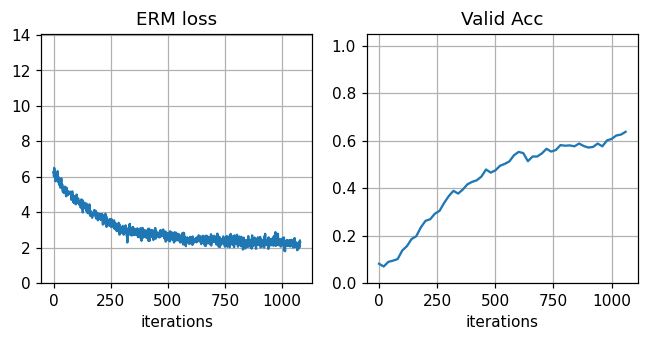

In [49]:
train_dl, valid_dl, test_dl = get_mnist_dl(batch_size_train=train_batch, batch_size_valid=valid_batch, device=DEVICE)

model = MLP_Nets(DEVICE)

stats = run_experiment(model, train_dl, valid_dl, test_dl, max_epochs=max_epochs, lr = lr)

print_stats(stats)